#Heart attack prediction 

### This markdown is for code for the datascience exam project 

Data analysis of Heart Attack Prediction dataset from Kaggle. Random forest classifiers.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
import pickle

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import classification_report



#import warnings
#warnings.filterwarnings("ignore")

In [4]:
# Load data
DF = pd.read_csv("heart.csv")

print(DF)


     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
0      0      1       1  

In [5]:
type(DF)
DF.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [6]:
# Chacking if there are any NAs
DF.isnull().values.any()

False

In [7]:
#Choose what variables you want in x. : before comma means all rows, :13 after comma means all the 13 first columns

x = DF.iloc[:, :13]
x

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [8]:
x.values

array([[63.,  1.,  3., ...,  0.,  0.,  1.],
       [37.,  1.,  2., ...,  0.,  0.,  2.],
       [41.,  0.,  1., ...,  2.,  0.,  2.],
       ...,
       [68.,  1.,  0., ...,  1.,  2.,  3.],
       [57.,  1.,  0., ...,  1.,  1.,  3.],
       [57.,  0.,  1., ...,  1.,  1.,  2.]])

In [9]:
y = DF.iloc[:, -1]
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: output, Length: 303, dtype: int64

In [10]:
y.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [11]:
# Split into train and testsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [ ]:
# Fit the model // train model1 on training data
model1 = RandomForestClassifier()
model1.fit(x_train, y_train)

In [13]:
# Test Model1 
prediction1 = model1.predict(x_test)

In [16]:
target_names = ["Low risk", "High risk"]

In [49]:
# Model performance
print(classification_report(y_test, prediction1, target_names= target_names))

              precision    recall  f1-score   support

    Low risk       0.81      0.70      0.75        30
   High risk       0.74      0.84      0.79        31

    accuracy                           0.77        61
   macro avg       0.78      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61



Training Model2 on all variables, but with 

Text(0, 0.5, 'Testing Accuracy')

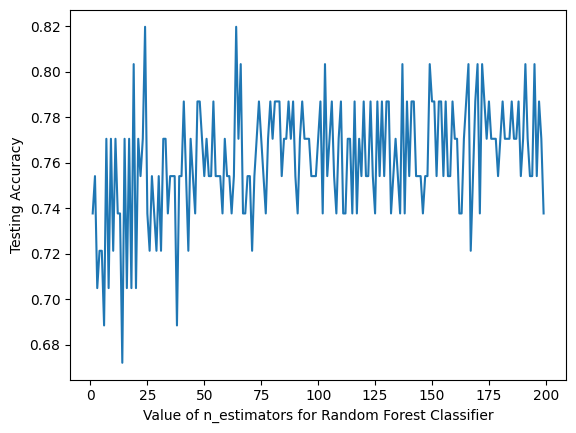

In [20]:
#from sklearn.metrics import accuracy_score
#scores =[]
#for k in range(1, 200):
 #   model2 = RandomForestClassifier(n_estimators=k)
 #   model2.fit(x_train, y_train)
 #   y_pred = model2.predict(x_test)
 #   scores.append(accuracy_score(y_test, y_pred))

#import matplotlib.pyplot as plt
#%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
#plt.plot(range(1, 200), scores)
#plt.xlabel('Value of n_estimators for Random Forest Classifier')
#plt.ylabel('Testing Accuracy')


So it seems that the testing accuracy does not get much better past an n_estimator value of 40-45 

In [50]:
## Fit the model // train model1 on training data
#model2 = RandomForestClassifier(max_features=13, n_estimators=45)
#model2.fit(x_train, y_train)

## Test Model1 
#prediction2 = model2.predict(x_test)

## Model performance
#print(classification_report(y_test, prediction2, target_names= target_names))

              precision    recall  f1-score   support

    Low risk       0.75      0.60      0.67        30
   High risk       0.68      0.81      0.74        31

    accuracy                           0.70        61
   macro avg       0.71      0.70      0.70        61
weighted avg       0.71      0.70      0.70        61



Build, train, test Model2

In [ ]:
#x2 = DF.iloc[:, :13]
#x2